In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df.shape

(7613, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


(-0.5, 1599.5, 799.5, -0.5)

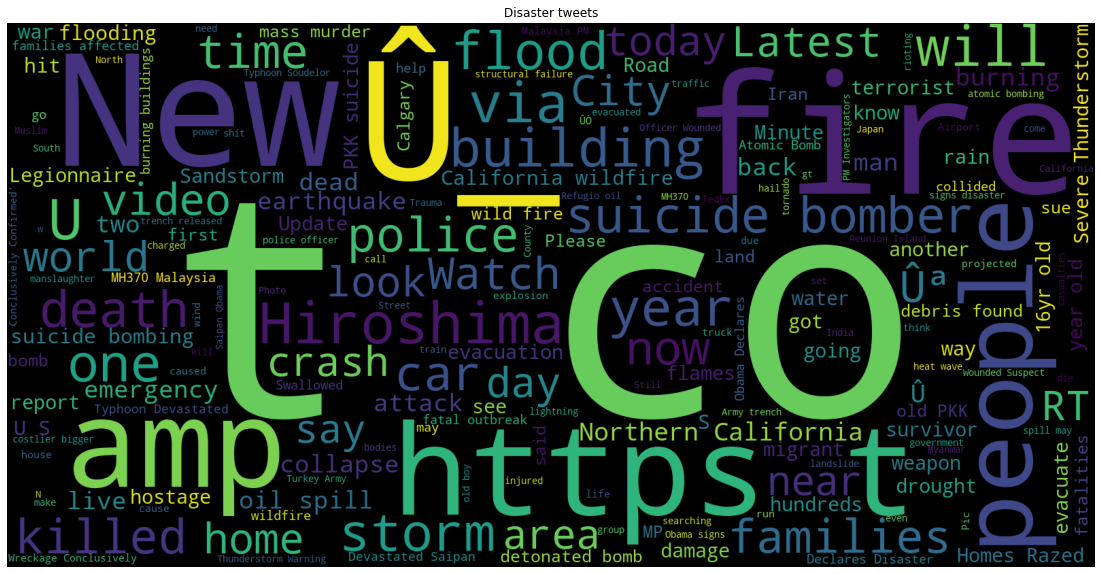

In [7]:
wd1 = pd.Series((df.loc[df['target']==1,'text']).tolist()).astype(str)
wordcloud1 = WordCloud(stopwords=STOPWORDS,width=1600,height=800,background_color='black').generate(" ".join(wd1))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud1)
plt.title("Disaster tweets")
plt.axis('off')

(-0.5, 1599.5, 799.5, -0.5)

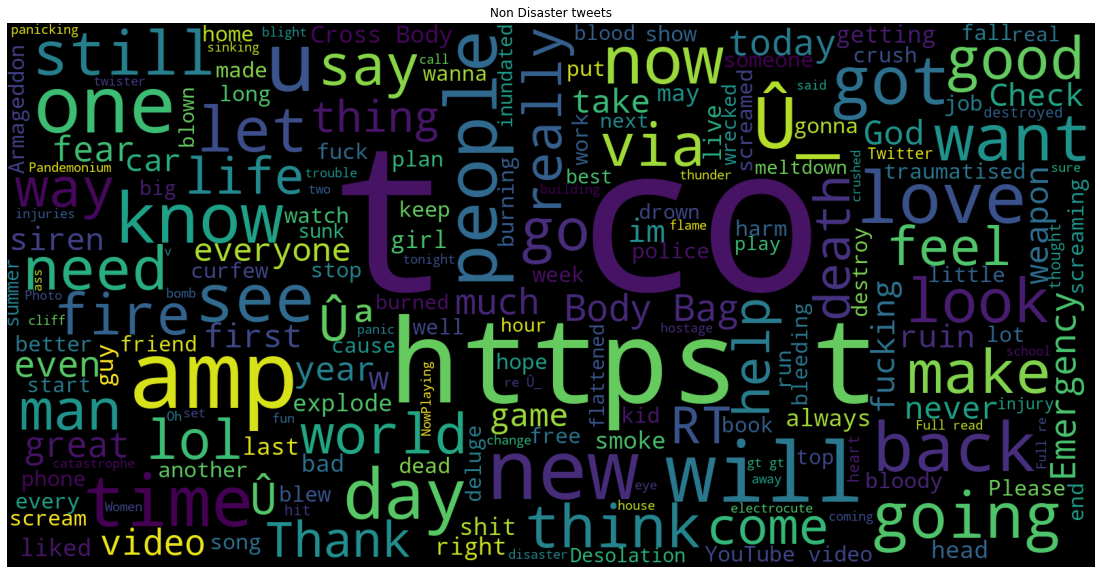

In [8]:
wd2 = pd.Series((df.loc[df['target']==0,'text']).tolist()).astype(str)
wordcloud2 = WordCloud(stopwords=STOPWORDS,width=1600,height=800,background_color='black').generate(" ".join(wd2))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud2)
plt.title("Non Disaster tweets")
plt.axis('off')

In [9]:
lemmatizer = WordNetLemmatizer()
corpus = []

In [10]:
for i in range(len(df)):
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*',' ', df['text'][i])
    text = re.sub('@[^\s]+',' ',text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = text.lower()
    text = text.split()
    text = [lemmatizer.lemmatize(i) for i in text if not i in set(stopwords.words('english'))]
    text = ' '.join(text)
    corpus.append(text)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(ngram_range=(1,3),max_features=5000)

In [12]:
X = cv.fit_transform(corpus).toarray()

In [13]:
X.shape

(7613, 5000)

In [14]:
y = df['target']

# 1.Multinomial NB

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.35,random_state=42)

In [16]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train,y_train)

MultinomialNB(alpha=0.1)

In [17]:
x_pred1 = nb.predict(X_train)
y_pred1 = nb.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score,plot_confusion_matrix
print("Training accuracy:",accuracy_score(y_train,x_pred1))
print("Testing accuracy:",accuracy_score(y_test,y_pred1))

Training accuracy: 0.8660064672594988
Testing accuracy: 0.800375234521576


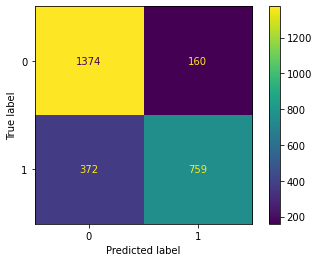

In [19]:
plot_confusion_matrix(nb,X_test,y_test,values_format='d')

# 2.Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [21]:
x_pred2 = lr.predict(X_train)
y_pred2 = lr.predict(X_test)

In [22]:
print("Training Accuracy:",accuracy_score(y_train,x_pred2))
print("Testing Accuracy:",accuracy_score(y_test,y_pred2))

Training Accuracy: 0.8718674211802748
Testing Accuracy: 0.8063789868667918


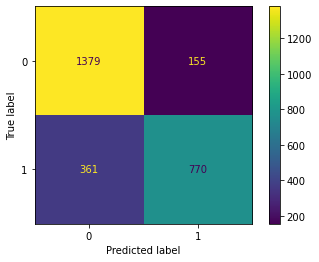

In [23]:
plot_confusion_matrix(lr,X_test,y_test,values_format='d')

# 3. Passive Aggressive classifier

In [24]:
from sklearn.linear_model import PassiveAggressiveClassifier
plc = PassiveAggressiveClassifier(max_iter=50)
plc.fit(X_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [25]:
x_pred3 = plc.predict(X_train)
y_pred3 = plc.predict(X_test)

In [26]:
print("Training Accuracy:",accuracy_score(y_train,x_pred3))
print("Testing Accuracy:",accuracy_score(y_test,y_pred3))

Training Accuracy: 0.9031932093775262
Testing Accuracy: 0.7399624765478424


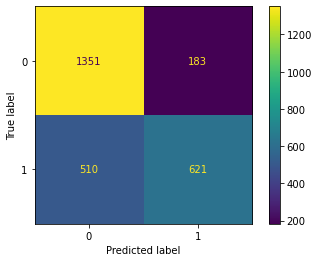

In [27]:
plot_confusion_matrix(plc,X_test,y_test,values_format='d')

# Pickle model

In [28]:
from pickle import dump,load
tfid = 'tfid.nav'
gnb = 'gnb.nav'

In [29]:
dump(cv,open(tfid,'wb'))
dump(nb,open(gnb,'wb'))

In [30]:
def preprocess(raw_mess):
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*',' ', raw_mess)
    text = re.sub('@[^\s]+',' ', text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = text.lower()
    text = text.split()
    text = [lemmatizer.lemmatize(i) for i in text if not i in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [31]:
def predict(mess):
    vect = load(open(tfid,'rb'))
    classifier = load(open(gnb,'rb'))
    clean = preprocess(mess)
    clean_encoded = vect.transform([clean])
    pred = classifier.predict(clean_encoded)
    return pred

In [32]:
tweet = input("Enter a tweet: ")
prediction = predict(tweet)
if prediction==1:
    print("It is a disastrous tweet")
else:
    print("It is a normal tweet")

Enter a tweet: 300 passengers died in a bus accident
It is a disastrous tweet


In [33]:
corpus

['deed reason earthquake may allah forgive u',
 'forest fire near la ronge sask canada',
 'resident asked shelter place notified officer evacuation shelter place order expected',
 'people receive wildfire evacuation order california',
 'got sent photo ruby alaska smoke wildfire pours school',
 'rockyfire update california hwy closed direction due lake county fire cafire wildfire',
 'flood disaster heavy rain cause flash flooding street manitou colorado spring area',
 'top hill see fire wood',
 'emergency evacuation happening building across street',
 'afraid tornado coming area',
 'three people died heat wave far',
 'haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding',
 'raining flooding florida tampabay tampa day lost count',
 'flood bago myanmar arrived bago',
 'damage school bus multi car crash breaking',
 'man',
 'love fruit',
 'summer lovely',
 'car fast',
 'goooooooaaaaaal',
 'ridiculous',
 'london cool',
 'love skiing',
 'wonderful day',
